In [1]:
# IF YOU WANT TO USE GOOGLE DRIVE FOR THIS PRACTICAL SESSION : 
#from google.colab import drive

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from TVL2 import *
from ULA import *

# Unadjusted Langevin Algorithm (ULA)


## Reminder on ULA

Assume that we want to sample from a target distribution $\pi \propto e^{-U}$, with $U:\mathbb{R}^d\rightarrow \mathbb{R}$ a known potential.

To this aim, we will use the Unadjusted Langevin Algorithm (ULA), which belongs to the family of MCMC methods, and relies on an Euler discretization of the  Langevin stochatic differential equation associated with $\pi$. 
The algorithm update step reads 
$$X_{k+1} = X_k - \delta \nabla U (X_k) +\sqrt{2\delta } Z_{k+1},$$
where $\delta$ is a step size and $(Z_k)$ a sequence of i.i.d. d dimensional standard Gaussian variables. 
$(X_k)$ is an homogeneous Markov chain.

Under some specific conditions on $U$ and $\delta$, it can be shown that the chain $(X_n)$ converges to its unique invariant distribution $\pi_{\delta}$, which is "close" to the target distribution $\pi \propto e^{-U}$.

Mainly, the assumptions on $U$ and $\delta$ are 
1. $U:\mathbb{R}^d\rightarrow \mathbb{R}$ is continuously differentiable and  such that $\nabla U$ is L-Lipschitz, i.e. such that
$$\forall x,y,\;\; \|\nabla U(x) - \nabla U (y)\| \le L \|x-y\|.$$
2. $U$ is strongly convex oustide a ball $B(0,R)$, i.e.
$$\forall x,y \text{ oustide }  B(0,R)\;\;  U(y) - U (x) \ge \langle\nabla U(x),y-x\rangle +\frac m 2 \|x-y\|^2.$$
3. $\delta \le \frac 1 L$.  

Observe that 1. implies that 
$$\forall x,y,\;\;  U(y) - U (x) \le   \langle \nabla U(x),y-x \rangle +\frac L 2 \|x-y\|^2.$$
Hence, 1. and 2. imply that the behaviour of $\pi$ outside $B(0,R)$ is not too far from a Gaussian.




## 1D experiment
In the following, we start by experimenting with ULA for sampling 1D distributions.
The conditions on ULA make it appropriate for distributions which are not too far from Gaussian distributions in practice.

1. Use ULA to sample the Gaussian distribution $\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$.
2. Starting from $X_0=0$ for instance, what is the distribution of $X_n$ after $n$ iterations of ULA?  Show that the asymptotic variance of the chain is $\frac 2 {2- \delta}$. What happens when $\delta=1$?

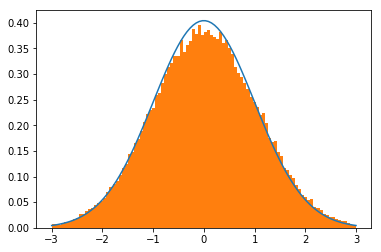

In [3]:
###### ULA 
x0 = 0
niter = int(1e5)
delta = .1

Y = ULA_gauss(niter,delta,x0)

#display result
x = np.linspace(-3,3,100)  
y = 1/(np.sqrt(2*np.pi))*np.exp(-x**2 /2)
plt.plot(x,y/np.sum(y)*100/6)
plt.hist(Y,bins=100,range=[-3,3],density=1)
plt.show()

## Using ULA to sample TVL2 with blur operator A 
We observe an image
$$u_b = Au_0+n$$
where the original image $u_0$ is unknown and the linear operator $A$ represents a (circular) convolution with a known kernel $h$, and $n$ represents i.i.d Gaussian noise. We wish to use ULA to sample from the distribution $\pi \propto e^{-U(u)}$ where
$$U(u) = \frac{1}{2\sigma^2}\|Au - u_b\|^2+ \alpha \mathrm{TV}(u). $$
If the blur operator $A$ is invertible (true for Gaussian blurs for instance), then the strong convexity assumption is valid. The TV term is not smooth, so we propose to use instead the Huber approximation of the total variation 
$$HTV(u) = \sum_{i\in \Omega} \|\nabla u(i)\|_\epsilon$$
where $$\|g\|_\epsilon = \begin{cases} \frac{\|g\|_2^2}{2\epsilon} & \text{ if } \|g\|_2 \le \epsilon \\ \|g\|_2 - \frac{\epsilon}{2} \text{ otherwise.}\end{cases}$$
$HTV(u)$ is smooth and its gradient is 
$$ \nabla HTV(u)_i = \begin{cases}  -\frac{1}{\epsilon} \mathrm{div} ({\nabla u_i})  & \text{ if } \|\nabla u_i\|_2 \le \epsilon \\  -\mathrm{div} \frac{\nabla u_i}{\|\nabla u_i\|_2}\text{ otherwise.}\end{cases}$$
If we use the most simple discrete scheme to compute the gradient, then $ \nabla HTV(u)$ is $\frac 8 \epsilon$ - Lipschitz for $\epsilon \le 1$. 


The ULA scheme can be written 
$$X_{k+1} = X_k - \frac{\delta}{\sigma^2}(A^* A X_k - A^* u_b) - \delta \nabla HTV(X_k) +\sqrt{2\delta } Z_{k+1},$$






1. Create the blurry image. 

For the sake of simplicity we will use in the following a uniform blur, even if it does not fulfill the invertibility condition. The matrix $A$ is never computed explicitely (it would be HUGE !), all the operations involving $A$ or $A^*$ must be written directly in the Fourier domain. For instance:  
- $Au$ is a convolution with the kernel $h$, it can be computed as 
$$\mathcal{F}^{-1} ( \hat{u}. \hat{h} )$$
with $\mathcal{F}$ the Fourier transform and $\mathcal{F}^{-1}$ the inverse Fourier transform.
- $A^*u$ is a convolution with the conjugate of the kernel $h$...
- the inversion $(Id+\sigma AA^*)^{-1} u $ in the Fourier domain becomes a division  $\frac{\hat{u}}{1+ \sigma |\hat{h}|^2}$ 

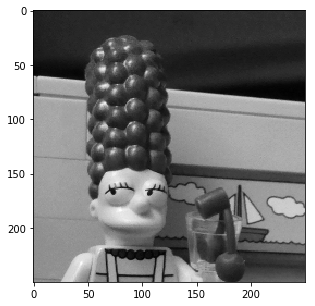

In [3]:
u = plt.imread('./images/simpson512.png')
u = u[0:250,0:250,1]
n_Rows, n_Col = u.shape
plt.figure(figsize = (5,5))
plt.imshow(u, cmap = 'gray')

In [4]:
#kernel definition    (for a 5x5 uniform kernel)
s = 2
h = np.zeros((u.shape[0],u.shape[1]))
h[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2
# convolution operation
convol  = lambda a,b:  np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b)))

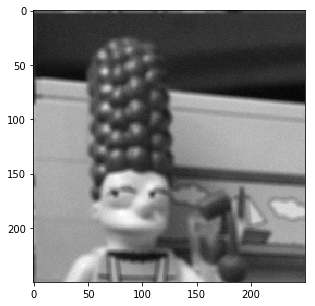

In [5]:
# blurred image + noise
sigma = 0.01
ub = convol(u,h) + sigma*np.random.randn(u.shape[0],u.shape[1])
plt.figure(figsize = (5,5))
plt.imshow(ub, cmap = 'gray')

In [18]:
# parameters for ULA
alpha = 30                    # weight of TV
epsilon = .01                 # regularization for HTV (since ULA needs differentiable potentials)
L = 1/sigma**2  + 8/epsilon   # Lipschitz constant
delta = 1/L                   # ULA step parameter 
n_iter = 5000                 # total number of iterations 
n_burn_in = int(0.1*n_iter)   # number of iterations for the burn-in phase 

# ULA iterations
t1 = time()
X_mean, Xf, std, X_samples, MMSE_error = ula_deblurring(ub, u, sigma = sigma, delta = delta, alpha = alpha, epsilon = epsilon, h = h,inter= 10,n_iter = n_iter, n_burn_in = n_burn_in)
print(time()-t1)

100%|██████████| 5000/5000 [00:35<00:00, 142.06it/s]

35.22713112831116


Text(0.5, 1.0, 'sampling quality')

<Figure size 432x288 with 0 Axes>

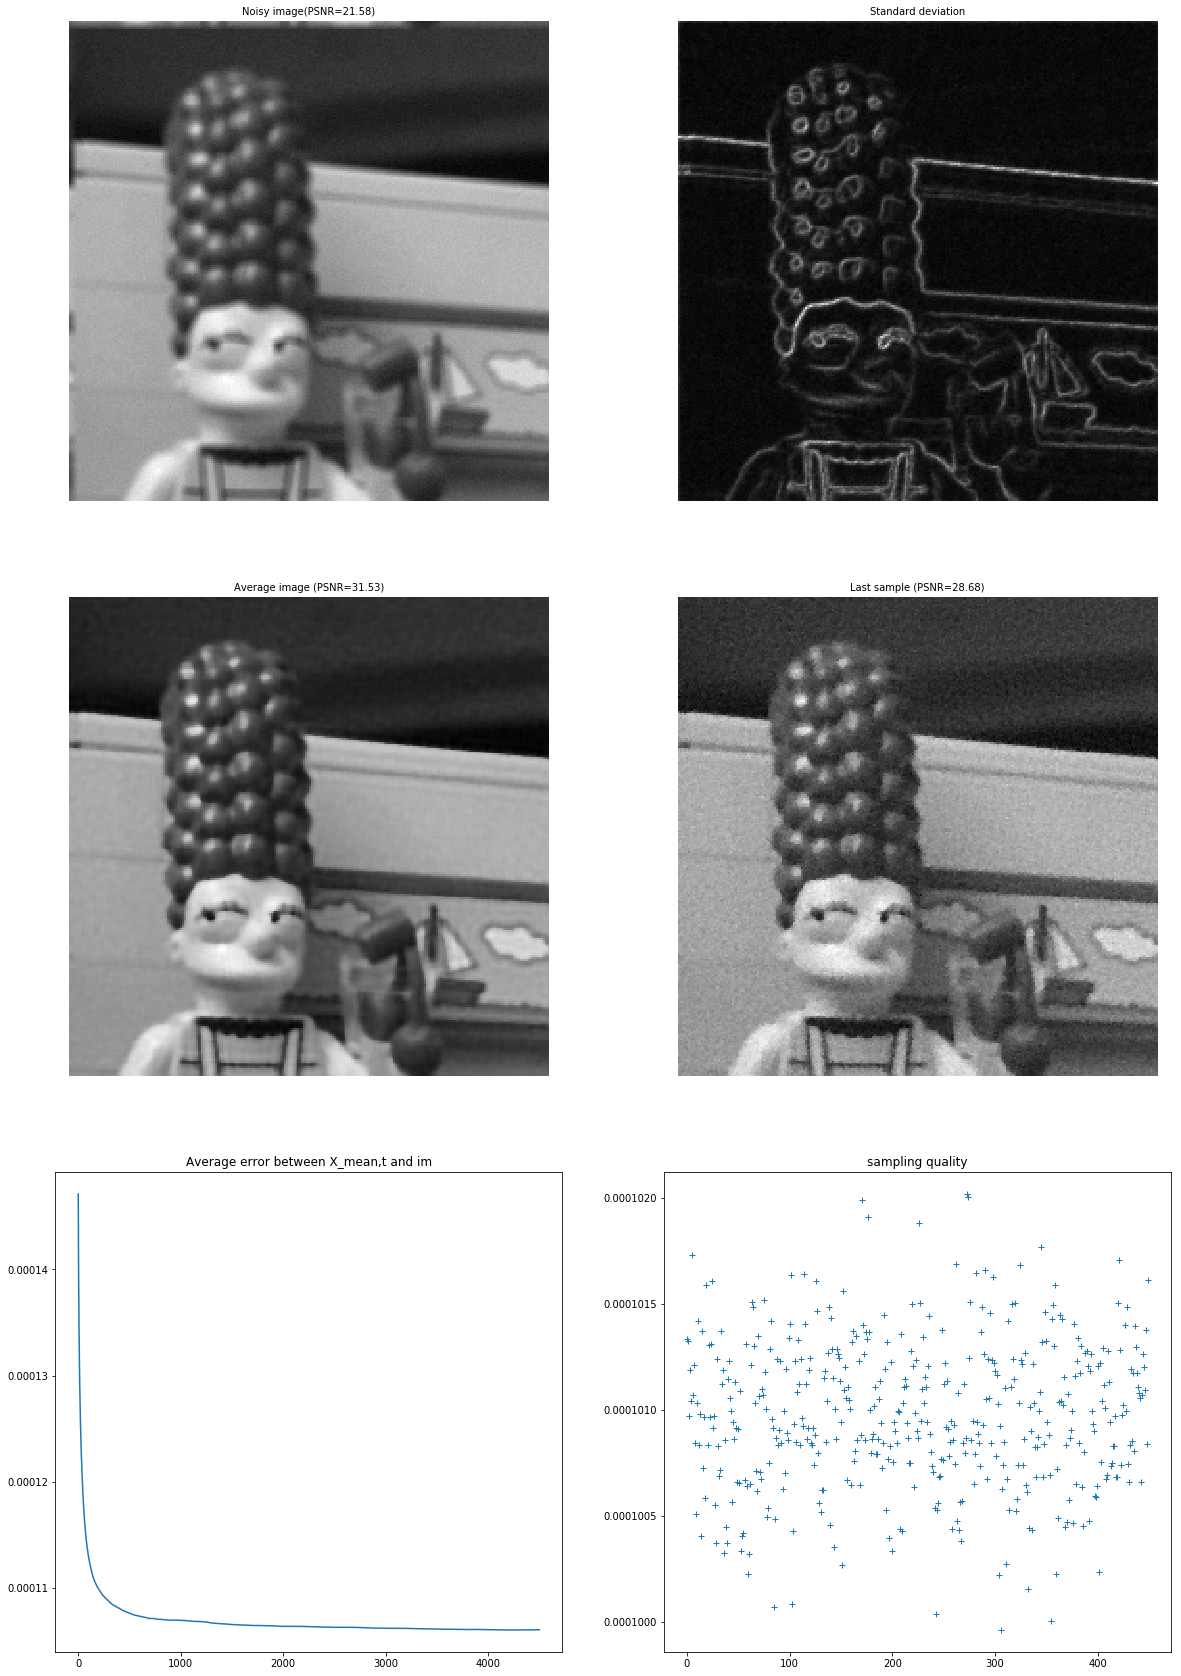

In [19]:
# Comparison plot
plt.figure()
fig = plt.figure(figsize = (20,30))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(ub, cmap = 'gray')
ax1.set_title('Noisy image(PSNR={:.2f})'.format(PSNR(u, ub)), fontsize = 10)
ax1.axis('off')
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(std, cmap = 'gray')
ax2.set_title('Standard deviation', fontsize = 10)
ax2.axis('off')
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(X_mean, cmap ='gray')
ax3.set_title('Average image (PSNR={:.2f})'.format(PSNR(u, X_mean)),fontsize = 10)
ax3.axis('off')
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(Xf, cmap ='gray')
ax4.set_title('Last sample (PSNR={:.2f})'.format(PSNR(u, Xf)),fontsize = 10)
ax4.axis('off')
ax5 = fig.add_subplot(3,2,5)
ax5.plot(MMSE_error)
ax5.set_title('Average error between X_mean,t and im')
ax6 = fig.add_subplot(3,2,6)
ax6.plot(1/(n_Rows*n_Col)*np.sqrt(np.sum(np.sum((X_samples[:,:,int(X_samples.shape[2]/10):] - X_mean[:,:,np.newaxis])**2,0),0)),'+')
ax6.set_title('sampling quality')



## Comparison with the MAP

Text(0.5, 1.0, 'MAP (PSNR=31.77)')

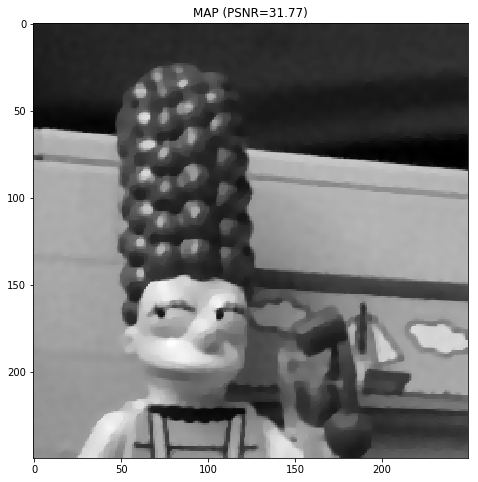

In [20]:
#deblurring Chambolle-Pock MAP
niter = 200

# TVL2 deblurring
ut = chambolle_pock_deblurring_TV(ub,h,sigma**2*alpha,niter)  

#display result
plt.figure(figsize = (8,8))
plt.imshow(ut,cmap='gray')
plt.title('MAP (PSNR={:.2f})'.format(PSNR(ut, u)))